# Problem C: Prediction of Traffic Flow based on Burgers’ Equation Model
Burgers' equation is a mathematical model used in various fields, including traffic flow, to represent the behavior of nonlinear systems with both convective and diffusive effects. In traffic flow, it captures the interactions between vehicles, such as the tendency for traffic to slow down when density increases (convection) and the tendency for traffic to spread out due to individual driver behavior (diffusion). 

The Burger's Equation for modeling traffic flow is given as follows:
\begin{equation}
u_t + uu_x = \nu u_{xx}, \quad x\in (-1,1),\ t\in(0,1] 
\end{equation}
Where:
- $u(x,t)$: car velocity (m/s),
- $\nu$: a diffusion coefficient (reflecting how drivers respond to nearby traffic; higher $\nu$ = more cautious drivers),
- $x$: position along the road,
- $t$: time.

We set $\nu=0.1$ and consider the Dirichlet boundary condition, i.e.:
$$
u(x=-1, t) = u(x=1, t)=0,\quad t\in(0,1]
$$

With this PDE model, once the initial velocity field $u(x,t=0)=a(x)$ is given, we can predict the velocity field $u(x,t)$ at any time $t>0$ by solving Burger's equation.

## Task: predicting the velocity filed $u(x,t)$ given the inital field $u(x,t=0)=a(x)$ 
In this task, we have collected many initial field $u(x,t=0)=a(x)$ which are sampled from a distribution $\mathcal{A}$. We have also computed the corresponding velocity field $u(x,t)$ by solving Burger's equation with a high-precision FDM method. Now, we hope to make a fast prediction of the velocity field $u(x,t)$ once a new initial condition $a(x)$ is given from the same distribution.

### The goals
- Please select a suitable deep learning method for solving this task, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $\{u^{(j)}_{pred}\}^{N}_{j}$ and the truth $\{u^{(j)}_{true}\}^{N}_j$ is defined as follows:
  $$error = \frac{1}{N}\sum_j\sqrt{\frac{\sum_i|u^{(j)}_{pred}(x_i, t_i)-u^{(j)}_{true}(x_i,t_i)|^2}{\sum_i|u^{(j)}_{true}(x_i, t_i)|^2}}$$
 where $j$ indicates the $j$-th instance.
- Plot the initial field, the corresponding predicted solution (and the ground truth reference), and the pointwise absolute error for the first instance in the testing Dataset using separate figures with ```matplotlib```.

### Dataset
The observation and the ground truth references are given in the dataset ```TrafficFlow.h5```:
- ```a_train```: size(1000, 128), the collected $N=1000$ initial fields (on $128$ sensors)
- ```u_train```: size(1000, 100, 128), the collected $N=1000$ velocity fields (on $100\times 128$ temporal-spatial regular meshgrids)
- ```a_test```: size(200, 128), the initial fields that we are going to predict their corresponding velocity field (Should not be used for training)
- ```u_test```: size(200, 100, 128), the ground truth reference of the velocity field (Should not be used for training)
- ```x_mesh```: size(128, 1), the spatial-coordiante of locations where the velocity field computed
- ```t_mesh```: size(100, 1), the temporal-coordiante of locations where the velocity field computed
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

Using device: cpu
<KeysViewHDF5 ['a_test', 'a_train', 't_mesh', 'u_test', 'u_train', 'x_mesh']>
torch.Size([100, 1])
torch.Size([128, 1])
torch.Size([200, 128])
torch.Size([200, 100, 128])
torch.Size([1000, 128])
torch.Size([1000, 100, 128])


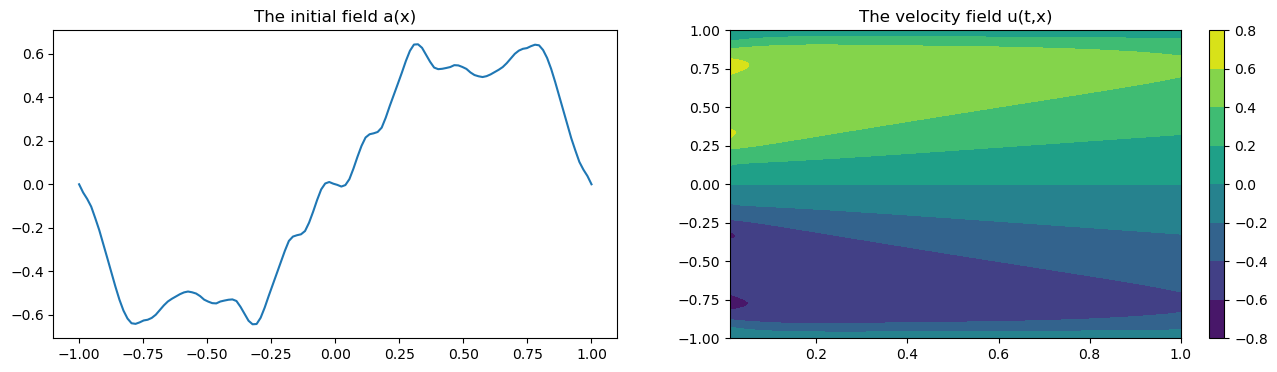

In [ ]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt
dtype = torch.float32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
######################################
# Load training data
######################################
with h5py.File('3rd_task/TrafficFlow.h5', 'r') as file:
    print(file.keys())
    t_mesh = torch.tensor(np.array(file['t_mesh']), dtype=dtype).to(device)
    x_mesh = torch.tensor(np.array(file['x_mesh']), dtype=dtype).to(device)
    a_test = torch.tensor(np.array(file['a_test']), dtype=dtype).to(device)
    u_test = torch.tensor(np.array(file['u_test']), dtype=dtype).to(device)
    a_train = torch.tensor(np.array(file['a_train']), dtype=dtype).to(device)
    u_train = torch.tensor(np.array(file['u_train']), dtype=dtype).to(device)
    #
    X, T = np.meshgrid(x_mesh.cpu().numpy(), t_mesh.cpu().numpy())
#
print(t_mesh.shape)
print(x_mesh.shape)
print(a_test.shape)
print(u_test.shape)
print(a_train.shape)
print(u_train.shape)
#################################
inx = 0
fig, axes = plt.subplots(1,2, figsize=(16,4))
#
cntr = axes[0].plot(x_mesh.cpu().numpy(), a_train[0].cpu().numpy())
axes[0].set_title('The initial field a(x)')
#
cntr = axes[1].contourf(T, X, u_train[inx].cpu().numpy())

axes[1].set_title('The velocity field u(t,x)')
plt.colorbar(cntr)
#
plt.show()

## Changing dimensions of matrices to match a FNO 2D

In [95]:
## a_train shape manipulation
print(a_train.shape)
if a_train.shape[1] == 128:
    a_train = a_train.unsqueeze(1).repeat(1, u_train.shape[1], 1)
    print(a_train.shape)
    a_train = a_train.unsqueeze(-1)  # Adding a channel dimension

print("The final a_train shape is:", a_train.shape)

# u_train shape manipulation
if u_train.ndim == 3:
    u_train = u_train.unsqueeze(-1)  # Adding a channel dimension



print("The shape of x_mesh:", x_mesh.shape)
print("The shape of t_mesh:", t_mesh.shape)

if x_mesh.shape[0] == 128 and t_mesh.shape[0] == 100:
    # x_mesh and t_mesh shape manipulation
    x_mesh = x_mesh.unsqueeze(0).unsqueeze(1)  # Adding batch and channel dimensions
    t_mesh = t_mesh.unsqueeze(0).unsqueeze(2)  # Adding batch and channel dimensions
    x_mesh = x_mesh.repeat(u_train.shape[0], a_train.shape[1], 1, 1)  # Repeat for batch size
    t_mesh = t_mesh.repeat(u_train.shape[0], 1, a_train.shape[2], 1)  # Repeat for batch size

print("The shape of x_mesh:", x_mesh.shape)
print("The shape of t_mesh:", t_mesh.shape)

print("\n" * 2)

## Creating input tensor
input_tensor = torch.cat([a_train, x_mesh, t_mesh], dim=-1)  # shape: (1000, 128, 100, 3)
print("Input tensor shape:", input_tensor.shape)
print("Output tensor shape:", u_train.shape)

torch.Size([1000, 128])
torch.Size([1000, 100, 128])
The final a_train shape is: torch.Size([1000, 100, 128, 1])
The shape of x_mesh: torch.Size([128, 1])
The shape of t_mesh: torch.Size([100, 1])
The shape of x_mesh: torch.Size([1000, 100, 128, 1])
The shape of t_mesh: torch.Size([1000, 100, 128, 1])



Input tensor shape: torch.Size([1000, 100, 128, 3])
Output tensor shape: torch.Size([1000, 100, 128, 1])


In [96]:
import torch.nn as nn

class SpectralConv2d(nn.Module):
    
    def __init__(self, in_size, out_size, modes1, modes2, dtype):
        super(SpectralConv2d, self).__init__()
        '''2D Fourier layer: FFT -> linear transform -> Inverse FFT
        '''
        self.in_size = in_size 
        self.out_size = out_size 
        self.modes1 = modes1
        self.modes2 = modes2 
        #
        self.scale = 1./(in_size * out_size)
        #
        if (dtype is None) or (dtype==torch.float32):
            ctype = torch.complex64 
        elif (dtype==torch.float64):
            ctype = torch.complex128 
        else:
            raise TypeError(f'No such data type.')
        #
        self.weight1 = nn.Parameter(self.scale * torch.rand(in_size, out_size, 
                                                            modes1, modes2, 
                                                            dtype=ctype))
        self.weight2 = nn.Parameter(self.scale * torch.rand(in_size, out_size, 
                                                            modes1, modes2, 
                                                            dtype=ctype))
    
    def compl_mul_2d(self, input, weights):
        '''Complex multiplication: (batch_size, in_size, m1, m2) * (in_size, out_size, m1, m2) -> (batch_size, out_size, m1, m2)
        '''
        return torch.einsum('bixy,ioxy->boxy', input, weights)

    def forward(self, x):
        '''
        Input:
            x: size(batch_size, in_size, my_size, mx_size)
        Return:
            x: size(batch_size, out_size, my_size, mx_size)
        '''
        batch_size = x.shape[0]
        ####################### Compute Fourier coefficients up to factor of e^{-c}
        x_ft = torch.fft.rfft2(x) # size(batch_size, in_size, mx_size, my_size//2+1)
        ######################## Multiply relevant Fourier modes
        out_ft = torch.zeros(batch_size, self.out_size, x.size(-2), x.size(-1)//2+1, 
                             device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] \
            = self.compl_mul_2d(x_ft[:, :, :self.modes1, :self.modes2], self.weight1)
        out_ft[:, :, -self.modes1:, :self.modes2] \
            = self.compl_mul_2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weight2)
        ######################### Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1))) # size(batch_size, out_size, mx_size, my_size)

        return x 
        
class FNO2d(nn.Module):

    def __init__(self, in_size:int, out_size:int, modes1:int, modes2:int, 
                 hidden_list:list[int], dtype=None):
        super(FNO2d, self).__init__()
        self.hidden_list = hidden_list
        # Activation
        self.activation = nn.ReLU()
        # The input layer: 
        self.fc_in = nn.Linear(in_size, hidden_list[0], dtype=dtype)
        # The hidden layer
        conv_net, w_net = [], []
        self.hidden_in = hidden_list[0]
        for hidden in hidden_list:
            conv_net.append(SpectralConv2d(self.hidden_in, hidden, modes1, modes2, dtype))
            w_net.append(nn.Conv1d(self.hidden_in, hidden, 1, dtype=dtype))
            self.hidden_in =  hidden 
        self.spectral_conv = nn.Sequential(*conv_net)
        self.weight_conv = nn.Sequential(*w_net)
        # The output layer
        self.fc_out0 = nn.Linear(self.hidden_in, 128, dtype=dtype)
        self.fc_out1 = nn.Linear(128, out_size, dtype=dtype)
    
    def forward(self, ax):
        '''
        Input: 
            ax: size(batch_size, my_size, mx_size, a_size+x_size)
        Output: 
            u: size(batch_size, my_size, mx_size, out_size)
        '''
        batch_size = ax.shape[0]
        mx_size, my_size = ax.shape[1], ax.shape[2]
        # The input layer: size(b, mx_size, my_size, in_size) -> (b, hidden_size, my_size, mx_size)
        ax = self.fc_in(ax)
        ax = ax.permute(0, 3, 1, 2)
        # The spectral conv layer 
        for conv, weight, hidden_size in zip(self.spectral_conv, self.weight_conv, self.hidden_list):
            ax1 = conv(ax)   # size(b, hidden_size, my_size, mx_size)
            ax2 = weight(ax.view(batch_size, hidden_size, -1)).view(batch_size, hidden_size, mx_size, my_size)
            ax = self.activation(ax1+ax2)
        # The output layer: size(batch_size, hidden_size, my_size, mx_size) -> size(batch_size, my_size, mx_size, out_size)
        ax = ax.permute(0, 2, 3, 1)
        ax = self.fc_out0(ax)
        ax = self.activation(ax)

        return self.fc_out1(ax)
#
mode1, mode2 = 8, 8
hidden_list = [40, 40, 40]
model_u = FNO2d(input_tensor.shape[-1], u_train.shape[-1], mode1, mode2, hidden_list).to(device)
################## Find total trainable parameters
total_trainable_params = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

624,857 training parameters.


In [97]:
class LossClass(object):

    def __init__(self, uT_model):
        self.device = device
        self.uT_model = uT_model 
    
    def loss_data(self, ax_batch, uT_batch):
        '''loss term'''
        batch_size = uT_batch.shape[0]
        ax, uT = ax_batch.to(self.device), uT_batch.to(self.device)
        #
        uT_pred = self.uT_model(ax)
        loss = torch.norm(uT.reshape(batch_size, -1)-uT_pred.reshape(batch_size, -1), 2, 1)
        loss = torch.mean(loss)
        
        return loss 

In [92]:
from tqdm import trange
from torch.utils.data import Dataset, DataLoader
import time
############# Define your own dataset 
class MyDataset(Dataset):

    def __init__(self, ax:torch.tensor, uT:torch.tensor):
        '''
        Input:
            ax: size(batch_size, a_size)
            uT: size(batch_size, uT_size)
        '''
        self.ax = ax
        self.uT = uT
    
    def __getitem__(self, index):
        return self.ax[index], self.uT[index]

    def __len__(self):
        return self.ax.shape[0]
        
train_loader = DataLoader(MyDataset(input_tensor, u_train), batch_size=50, shuffle=True)

################# Training setups
epochs = 1000
lr = 1e-3
optimizer = torch.optim.Adam(params=model_u.parameters(), lr=lr, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)
loss_list = []
t0 = time.time()
for epoch in trange(epochs):
    loss = 0.
    for a_batch, uT_batch in train_loader:
        lossClass = LossClass(model_u)
        loss_train = lossClass.loss_data(a_batch, uT_batch)
        #
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        #
        loss += loss_train
    #
    scheduler.step()  # Adjust learning rate
    #
    loss = loss/len(train_loader)
    loss_list.append(loss.item())
    if (epoch+1)%100==0:
        print(f'Epoch:{epoch}, The loss is:{loss.item()}')
print('The consuming time is:', time.time()-t0)

  0%|          | 1/1000 [01:45<29:18:48, 105.63s/it]


KeyboardInterrupt: 

In [ ]:
######################################
# Load testing data
######################################
data_test = h5py.File('Burgers_test.mat', 'r')
print(data_test.keys()) 
#
ax_test, uT_test, x_test = get_data(data_test, dtype)
print('The shape of ax_test:', ax_test.shape)
print('The shape of uT_test:', uT_test.shape)
print('The shape of x_test:', x_test.shape)
#######################################
# The L2 relative error
#######################################
def L2_error(uT, uT_pred):
    ''' '''
    ndata = uT.shape[0]
    l2 = torch.norm(uT.reshape(ndata,-1)-uT_pred.reshape(ndata,-1), 2, 1) / torch.norm(uT.reshape(ndata,-1), 2, 1)
    return l2
# Make prediction with trained model
uT_test_pred = model_uT(ax_test.to(device)).detach().cpu()
print('The shape of uT_pred:', uT_test_pred.shape)
# compute the L2 relative error
l2_err = L2_error(uT_test, uT_test_pred)
print('The l2 error:', l2_err)
print('The average l2 error:', torch.mean(l2_err))
#######################################
# Visualize the prediction and truth u
#######################################
inx = 0
uT_true, uT_pred = uT_test[inx], uT_test_pred[inx]
#
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
#
axs.flat[:][0].plot(x_test.flatten(), uT_true.flatten(), color='r')
axs.flat[:][0].set_title('True uT')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('uT')
#
axs.flat[:][1].plot(x_test.flatten(), uT_true.flatten(), color='r')
axs.flat[:][1].plot(x_test.flatten(), uT_true.flatten(), color='green')
axs.flat[:][1].set_title('Pred. uT')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('uT')
#
axs.flat[:][2].plot(x_test.flatten(), (uT_true - uT_true).flatten(), color='blue')
axs.flat[:][2].set_title('Point-wise absolute error')
axs.flat[:][2].set_xlabel('x')
axs.flat[:][2].set_ylabel('abs error')
#
plt.show()